### Descripcion del proyecto
Una empresa automotriz tiene planes de ingresar a nuevos mercados con sus productos actuales (P1, P2, P3, P4 y P5). Después de una investigación de mercado exhaustiva, han concluido que el comportamiento del nuevo mercado es similar al de su mercado actual.

En su mercado actual, el equipo de ventas ha clasificado a todos los clientes en 4 segmentos (A, B, C, D). Luego, realizaron campañas de comunicación y acercamiento personalizadas para cada uno de estos segmentos. Esta estrategia ha funcionado **excepcionalmente bien** para ellos. Ahora planean usar la misma estrategia en los nuevos mercados y han identificado a **2627 nuevos clientes potenciales.**

# 1. Cargar Datos
Se comienza ubicando la ruta de los archivos de los datos para posteriormente cargarlos en una variable usando pandas.

In [145]:
import pandas as pd

# Cargar los datos de entrenamiento y prueba
train_df = pd.read_csv('data/Train.csv')
test_df = pd.read_csv('data/Test.csv')

# Mostrar las primeras filas para explorar
print('Train:')
display(train_df.head(5))
print('Test:')
display(test_df.head(5))

Train:


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


Test:


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6,B
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6,A
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6,A
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6,B
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6,A


# 2. Algoritmo Clustering (k-Means)
En esta sección se realiza el proceso de clustering utilizando el algoritmo K-Means.
El objetivo es agrupar a los clientes en segmentos similares según sus características, permitiendo identificar patrones y perfiles de clientes.

In [146]:
# Algoritmo K-Means con scikit-learn
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Ejemplo simple de uso
X_real_demo = train_df[['Age', 'Family_Size']].dropna().sample(12).values # Tomar 12 datos aleatorios de ['Age', 'Family_Size']
X_demo = X_real_demo # Usar datos reales para la demostración

k_demo = 2
kmeans = KMeans(n_clusters=k_demo, random_state=42)
labels_demo = kmeans.fit_predict(X_demo) # fit_predict | ajusta el modelo y asigna etiquetas a c/punto a un cluster
centroides_demo = kmeans.cluster_centers_ # cluster_centers_ | centroides finales de los clusters

print("Datos de entrada:\n", X_demo)
print("Etiquetas asignadas:\n", labels_demo)
print("Centroides:\n", centroides_demo)

Datos de entrada:
 [[31.  4.]
 [71.  2.]
 [31.  2.]
 [83.  2.]
 [75.  2.]
 [29.  3.]
 [42.  2.]
 [65.  2.]
 [25.  9.]
 [23.  3.]
 [43.  1.]
 [43.  2.]]
Etiquetas asignadas:
 [1 0 1 0 0 1 1 0 1 1 1 1]
Centroides:
 [[73.5    2.   ]
 [33.375  3.25 ]]


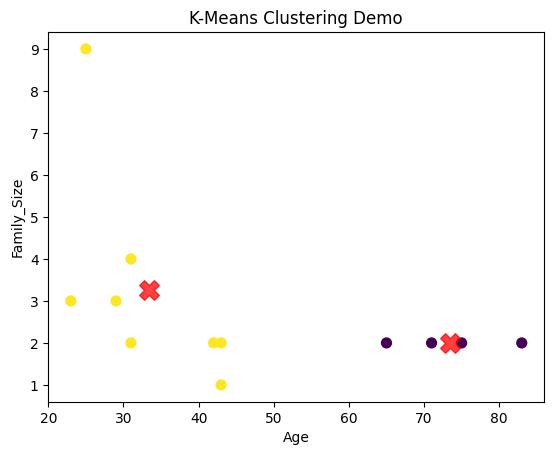

In [147]:
#Visualización de los clusters
plt.scatter(X_demo[:, 0], X_demo[:, 1], c=labels_demo, s=50, cmap='viridis')
plt.scatter(centroides_demo[:, 0], centroides_demo[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Centroides
plt.title('K-Means Clustering Demo')
plt.xlabel('Age')
plt.ylabel('Family_Size')
plt.show()


# 3. Proceso de desarrollo

### a) Ingeneria de características (Feature Engineering)
técnicas para transformar, limpiar y mejorar los datos según las necesidades del modelo:

- Codificación de variables categóricas (OneHotEncoder, LabelEncoder)
- Normalización o estandarización (StandardScaler, MinMaxScaler) → fundamental para K-Means
- Transformaciones logarítmicas (para variables con colas pesadas)
- Binning (agrupación de variables continuas como edad)
- Agregaciones (crear nuevas variables, por ejemplo, ingreso por edad)
- Selección de características (remover ruido y redundancia)

> “Mejores características permiten usar modelos menos complejos que se ejecutan más rápido…”

In [148]:
# Antes del Feature Engineering
print('Antes del Feature Engineering:')

# Columnas originales relevantes
cols_originales = ['Gender', 'Profession', 'Spending_Score', 'Age', 'Family_Size', 'Work_Experience']
display(train_df[cols_originales].head(10))

Antes del Feature Engineering:


,Gender,Profession,Spending_Score,Age,Family_Size,Work_Experience
0,Male,Healthcare,Low,22,4.0,1.0
1,Female,Engineer,Average,38,3.0,NaN
2,Female,Engineer,Low,67,1.0,1.0
3,Male,Lawyer,High,67,2.0,0.0
4,Female,Entertainment,High,40,6.0,NaN
5,Male,Artist,Average,56,2.0,0.0
6,Male,Healthcare,Low,32,3.0,1.0
7,Female,Healthcare,Low,33,3.0,1.0
8,Female,Engineer,Low,61,3.0,0.0
9,Female,Artist,Average,55,4.0,1.0


In [149]:
# Feature Engineering
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

In [150]:
#==============================================================================
# A1) Codificación de variables categóricas
#==============================================================================
# Crear copia del dataframe
train_processed = train_df.copy()

# Rellenar valores nulos antes de transformar
train_processed['Age'] = train_processed['Age'].fillna(train_processed['Age'].median())
train_processed['Family_Size'] = train_processed['Family_Size'].fillna(train_processed['Family_Size'].median())
train_processed['Work_Experience'] = train_processed['Work_Experience'].fillna(0)
train_processed['Spending_Score'] = train_processed['Spending_Score'].fillna('Low')
train_processed['Gender'] = train_processed['Gender'].fillna(train_processed['Gender'].mode()[0])
train_processed['Profession'] = train_processed['Profession'].fillna(train_processed['Profession'].mode()[0])
train_processed['Ever_Married'] = train_processed['Ever_Married'].fillna(train_processed['Ever_Married'].mode()[0])
train_processed['Graduated'] = train_processed['Graduated'].fillna(train_processed['Graduated'].mode()[0])
train_processed['Var_1'] = train_processed['Var_1'].fillna(train_processed['Var_1'].mode()[0])

# Codificar variables categóricas con LabelEncoder | 
train_processed['Gender_encoded'] = LabelEncoder().fit_transform(train_processed['Gender'])
train_processed['Profession_encoded'] = LabelEncoder().fit_transform(train_processed['Profession'])
train_processed['Spending_Score_encoded'] = LabelEncoder().fit_transform(train_processed['Spending_Score'])
train_processed['Ever_Married_encoded'] = LabelEncoder().fit_transform(train_processed['Ever_Married'])
train_processed['Graduated_encoded'] = LabelEncoder().fit_transform(train_processed['Graduated'])
train_processed['Var_1_encoded'] = LabelEncoder().fit_transform(train_processed['Var_1'])


In [151]:
#==============================================================================
# A2) Binning (antes de normalizar)
#==============================================================================
# Agrupar 'Age' en categorías usando los valores originales
train_processed['Age_bin'] = pd.cut(train_processed['Age'],
                                    bins=[0, 25, 40, 60, 100],
                                    labels=['Joven', 'Adulto', 'Maduro', 'Mayor'])

train_processed['Age_bin'] = train_processed['Age_bin'].fillna('Adulto')
train_processed['Age_bin_encoded'] = LabelEncoder().fit_transform(train_processed['Age_bin'].astype(str))

In [152]:

#==============================================================================
# A3) Transformaciones logarítmicas (antes de normalizar)
#==============================================================================
# Aplicar log a 'Work_Experience' para reducir colas pesadas
train_processed['Work_Experience_log'] = np.log1p(train_processed['Work_Experience'])


In [153]:

#==============================================================================
# A4) Agregaciones (antes de normalizar)
#==============================================================================
# Crear variable de gasto por miembro de familia
train_processed['Gasto_por_miembro'] = train_processed['Spending_Score_encoded'] / (train_processed['Family_Size'] + 1)


In [154]:
#==============================================================================
# A5) Normalización o estandarizacion.
#==============================================================================
# Seleccionar variables numéricas para normalizar
num_vars_to_scale = ['Age', 'Family_Size', 'Work_Experience_log', 'Gasto_por_miembro']
scaler = StandardScaler()
train_processed[num_vars_to_scale] = scaler.fit_transform(train_processed[num_vars_to_scale])


formula:

$$
X_{scaled} = \frac{X - \mu}{\sigma}
$$

Donde:
- $X$ es el valor original
- $\mu$ es la media de la columna | (sumar todos los valores y dividir por el número de valores)
- $\sigma$ es la desviación estándar de la columna | ( medida de dispersión de los datos respecto a la media)


In [155]:
#==============================================================================
# A6) seleccionar caracteristicas finales
#==============================================================================
# Incluir todas las variables relevantes para clustering
features_finales = [
    'Gender_encoded',
    'Ever_Married_encoded',
    'Graduated_encoded',
    'Profession_encoded',
    'Spending_Score_encoded',
    'Var_1_encoded',
    'Age',
    'Family_Size',
    'Work_Experience_log',
    'Age_bin_encoded',
    'Gasto_por_miembro'
]

X = train_processed[features_finales].copy()

In [156]:
# Visualizacion
print('Dataset procesado con Feature Engineering:')
print(f'Número de filas: {X.shape[0]}')
print(f'Número de características: {X.shape[1]}')
print('\nPrimeras filas del dataset procesado:')
display(X.head(10))
#print('\nEstadísticas descriptivas:')
#display(X.describe().round(2))

Dataset procesado con Feature Engineering:
Número de filas: 8068
Número de características: 11

Primeras filas del dataset procesado:


,Gender_encoded,Ever_Married_encoded,Graduated_encoded,Profession_encoded,Spending_Score_encoded,Var_1_encoded,Age,Family_Size,Work_Experience_log,Age_bin_encoded,Gasto_por_miembro
0,1,0,0,5,2,3,-1.284623,0.762698,-0.144919,1,-0.081736
1,0,1,1,2,0,3,-0.327151,0.095802,-0.961197,0,-1.254438
2,0,1,1,2,2,5,1.408268,-1.237990,-0.144919,3,1.677316
3,1,1,1,7,1,5,1.408268,-0.571094,-0.961197,3,-0.277186
4,0,1,1,3,1,5,-0.207467,2.096491,-0.961197,0,-0.835616
5,1,1,0,0,0,5,0.750006,-0.571094,-0.961197,2,-1.254438
6,1,0,1,5,2,5,-0.686203,0.095802,-0.144919,0,0.211439
7,0,0,1,5,2,5,-0.626361,0.095802,-0.144919,0,0.211439
8,0,1,1,2,2,6,1.049216,0.095802,-0.961197,3,0.211439
9,0,1,1,0,0,5,0.690164,0.762698,-0.144919,2,-1.254438


In [157]:
# Tablas de equivalencia para variables codificadas
print('=== TABLAS DE EQUIVALENCIA PARA INTERPRETACIÓN ===')
print('\nEstas tablas muestran cómo se codificaron las variables categóricas:\n')

# Gender
print('1. Género (Gender):')
gender_equiv = pd.DataFrame({
    'Código': sorted(train_processed['Gender_encoded'].unique()),
    'Valor Original': [train_processed[train_processed['Gender_encoded'] == i]['Gender'].iloc[0] 
                       for i in sorted(train_processed['Gender_encoded'].unique())]
})
display(gender_equiv)

# Ever_Married
print('\n2. Estado Civil (Ever_Married):')
married_equiv = pd.DataFrame({
    'Código': sorted(train_processed['Ever_Married_encoded'].unique()),
    'Valor Original': [train_processed[train_processed['Ever_Married_encoded'] == i]['Ever_Married'].iloc[0] 
                       for i in sorted(train_processed['Ever_Married_encoded'].unique())]
})
display(married_equiv)

# Graduated
print('\n3. Graduado (Graduated):')
grad_equiv = pd.DataFrame({
    'Código': sorted(train_processed['Graduated_encoded'].unique()),
    'Valor Original': [train_processed[train_processed['Graduated_encoded'] == i]['Graduated'].iloc[0] 
                       for i in sorted(train_processed['Graduated_encoded'].unique())]
})
display(grad_equiv)

# Profession
print('\n4. Profesión (Profession):')
prof_equiv = pd.DataFrame({
    'Código': sorted(train_processed['Profession_encoded'].unique()),
    'Valor Original': [train_processed[train_processed['Profession_encoded'] == i]['Profession'].iloc[0] 
                       for i in sorted(train_processed['Profession_encoded'].unique())]
})
display(prof_equiv)

# Spending_Score
print('\n5. Nivel de Gasto (Spending_Score):')
score_equiv = pd.DataFrame({
    'Código': sorted(train_processed['Spending_Score_encoded'].unique()),
    'Valor Original': [train_processed[train_processed['Spending_Score_encoded'] == i]['Spending_Score'].iloc[0] 
                       for i in sorted(train_processed['Spending_Score_encoded'].unique())]
})
display(score_equiv)

# Var_1
print('\n6. Variable Anonimizada (Var_1):')
var1_equiv = pd.DataFrame({
    'Código': sorted(train_processed['Var_1_encoded'].unique()),
    'Valor Original': [train_processed[train_processed['Var_1_encoded'] == i]['Var_1'].iloc[0] 
                       for i in sorted(train_processed['Var_1_encoded'].unique())]
})
display(var1_equiv)

# Age_bin
print('\n7. Categoría de Edad (Age_bin):')
age_bin_equiv = pd.DataFrame({
    'Código': [0, 1, 2, 3],
    'Valor Original': ['Adulto', 'Joven', 'Maduro', 'Mayor'],
    'Rango de Edad': ['40-60 años', '0-25 años', '25-40 años', '60+ años']
})
display(age_bin_equiv)

=== TABLAS DE EQUIVALENCIA PARA INTERPRETACIÓN ===

Estas tablas muestran cómo se codificaron las variables categóricas:

1. Género (Gender):


,Código,Valor Original
0,0,Female
1,1,Male



2. Estado Civil (Ever_Married):


,Código,Valor Original
0,0,No
1,1,Yes



3. Graduado (Graduated):


,Código,Valor Original
0,0,No
1,1,Yes



4. Profesión (Profession):


,Código,Valor Original
0,0,Artist
1,1,Doctor
2,2,Engineer
3,3,Entertainment
4,4,Executive
5,5,Healthcare
6,6,Homemaker
7,7,Lawyer
8,8,Marketing



5. Nivel de Gasto (Spending_Score):


,Código,Valor Original
0,0,Average
1,1,High
2,2,Low



6. Variable Anonimizada (Var_1):


,Código,Valor Original
0,0,Cat_1
1,1,Cat_2
2,2,Cat_3
3,3,Cat_4
4,4,Cat_5
5,5,Cat_6
6,6,Cat_7



7. Categoría de Edad (Age_bin):


,Código,Valor Original,Rango de Edad
0,0,Adulto,40-60 años
1,1,Joven,0-25 años
2,2,Maduro,25-40 años
3,3,Mayor,60+ años


### b) Clustering con K-Means
- Determinar el número óptimo de clusters usando el Método del Codo con la métrica WCSS (Within-Cluster Sum of Squares)

- Aplicar el algoritmo K-Means:

`from sklearn.cluster import KMeans kmeans = KMeans(n_clusters=optimal_k, random_state=42) clusters = kmeans.fit_predict(X_scaled)`

In [166]:
# Clustering con K-Means
# Determinar el número óptimo de clusters usando el Método del Codo (WCSS)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

print('=== DETERMINACION DEL NUMERO OPTIMO DE CLUSTERS ===')
print('Probando diferentes valores de K desde 2 hasta 10...\n')

wcss = []
K_range = range(2, 11)  # Probar K desde 2 hasta 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)  # Ajustar el modelo
    wcss.append(kmeans.inertia_)  # inertia_ = WCSS
    print(f'K={k}: WCSS = {kmeans.inertia_:.2f}')

=== DETERMINACION DEL NUMERO OPTIMO DE CLUSTERS ===
Probando diferentes valores de K desde 2 hasta 10...

K=2: WCSS = 89443.18
K=3: WCSS = 75281.21
K=4: WCSS = 61906.26
K=5: WCSS = 56513.36
K=6: WCSS = 52375.73
K=7: WCSS = 49110.65
K=8: WCSS = 46218.16
K=6: WCSS = 52375.73
K=7: WCSS = 49110.65
K=8: WCSS = 46218.16
K=9: WCSS = 44445.35
K=10: WCSS = 42018.11
K=9: WCSS = 44445.35
K=10: WCSS = 42018.11


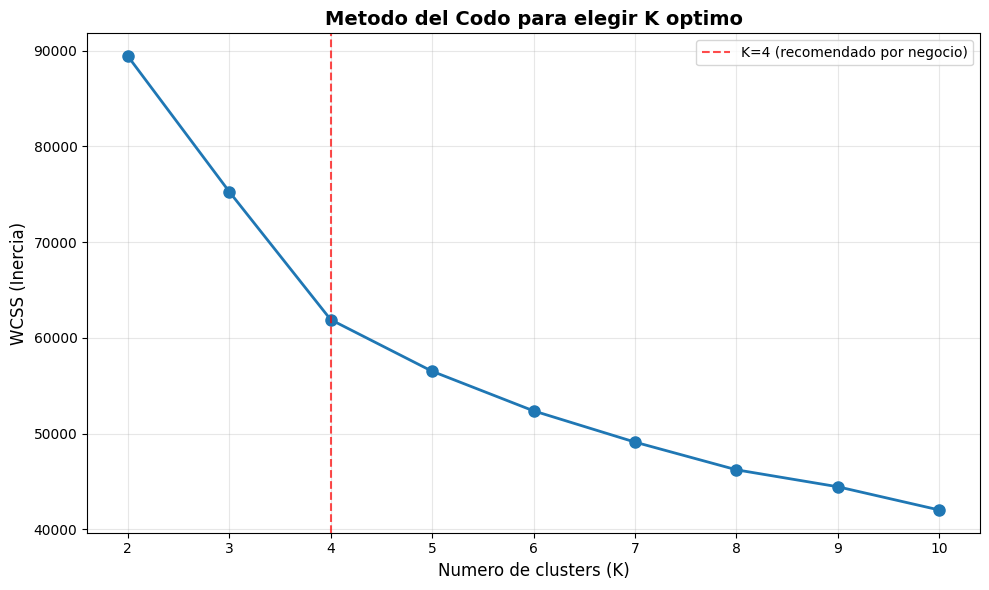

In [168]:
# visualizacion del metodo del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linewidth=2, markersize=8)
plt.title('Metodo del Codo para elegir K optimo', fontsize=14, fontweight='bold')
plt.xlabel('Numero de clusters (K)', fontsize=12)
plt.ylabel('WCSS (Inercia)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(K_range)

# Marcar K=4 como punto recomendado (según el contexto del negocio)
plt.axvline(x=4, color='r', linestyle='--', alpha=0.7, label='K=4 (recomendado por negocio)')
plt.legend()
plt.tight_layout()
plt.show()

In [172]:

print('\n=== ANALISIS DEL METODO DEL CODO ===')
print('Observando el gráfico, vemos que el "codo" donde la reducción del WCSS se hace menos pronunciada.')
print('(4 segmentos: A, B, C, D), elegimos K=4.\n')

# Aplicar K-Means con K=4
optimal_k = 4
print(f'Aplicando K-Means con K={optimal_k}...')

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X)

# Añadir los clusters al DataFrame
X['Cluster'] = clusters
train_processed['Cluster'] = clusters

print(f'Inercia final (WCSS): {kmeans_final.inertia_:.2f}')
print(f'Número de iteraciones: {kmeans_final.n_iter_}')



=== ANALISIS DEL METODO DEL CODO ===
Observando el gráfico, vemos que el "codo" donde la reducción del WCSS se hace menos pronunciada.
(4 segmentos: A, B, C, D), elegimos K=4.

Aplicando K-Means con K=4...
Inercia final (WCSS): 61906.26
Número de iteraciones: 10


In [ ]:

# Mostrar la distribución de elementos por cluster
print('\n=== DISTRIBUCIÓN DE CLIENTES POR CLUSTER ===')
cluster_counts = X['Cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(X)) * 100
    print(f'Cluster {cluster_id}: {count} clientes ({percentage:.1f}%)')

print(f'\nTotal de clientes: {len(X)}')



Clustering completado exitosamente!
Inercia final (WCSS): 61906.30
Número de iteraciones: 16

=== DISTRIBUCIÓN DE CLIENTES POR CLUSTER ===
Cluster 0: 2483 clientes (30.8%)
Cluster 1: 2506 clientes (31.1%)
Cluster 2: 1001 clientes (12.4%)
Cluster 3: 2078 clientes (25.8%)

Total de clientes: 8068


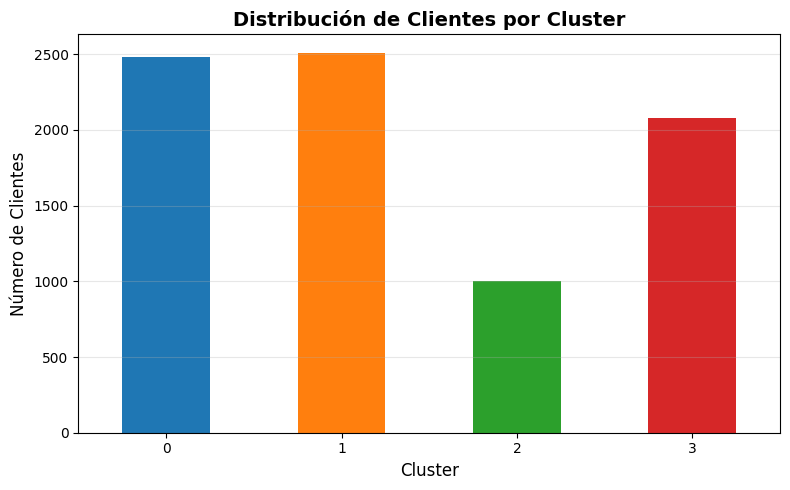

In [173]:
# Visualizar distribución
plt.figure(figsize=(8, 5))
cluster_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Distribución de Clientes por Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### c) visualizacion de resultados
Usar técnicas como:

- Elige las 3 dimensiones mas importantes para el modelo y grafica los clusters
- Gráficos de dispersión 2D/3D con color por cluster
- Perfiles de cliente por cluster (descripción textual + media de variables)

=== VISUALIZACIÓN DE RESULTADOS DEL CLUSTERING ===

Generando gráficos 2D, 3D y perfiles de clusters...



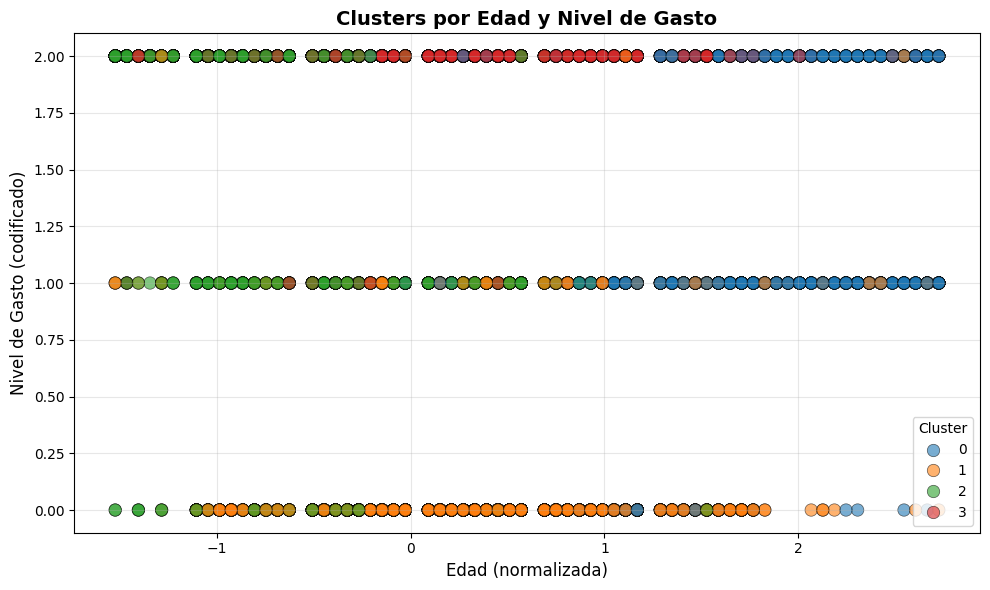

In [175]:
# Visualización de resultados de clustering
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

print('=== VISUALIZACIÓN DE RESULTADOS DEL CLUSTERING ===')
print('\nGenerando gráficos 2D, 3D y perfiles de clusters...\n')

# Definir paleta de colores para 4 clusters
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

#==============================================================================
# 1. Gráfico de dispersión 2D: Edad vs. Spending_Score
#==============================================================================
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X['Age'], y=X['Spending_Score_encoded'], 
                hue=X['Cluster'], palette=colors, s=80, alpha=0.6, edgecolor='black', linewidth=0.5)
plt.title('Clusters por Edad y Nivel de Gasto', fontsize=14, fontweight='bold')
plt.xlabel('Edad (normalizada)', fontsize=12)
plt.ylabel('Nivel de Gasto (codificado)', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

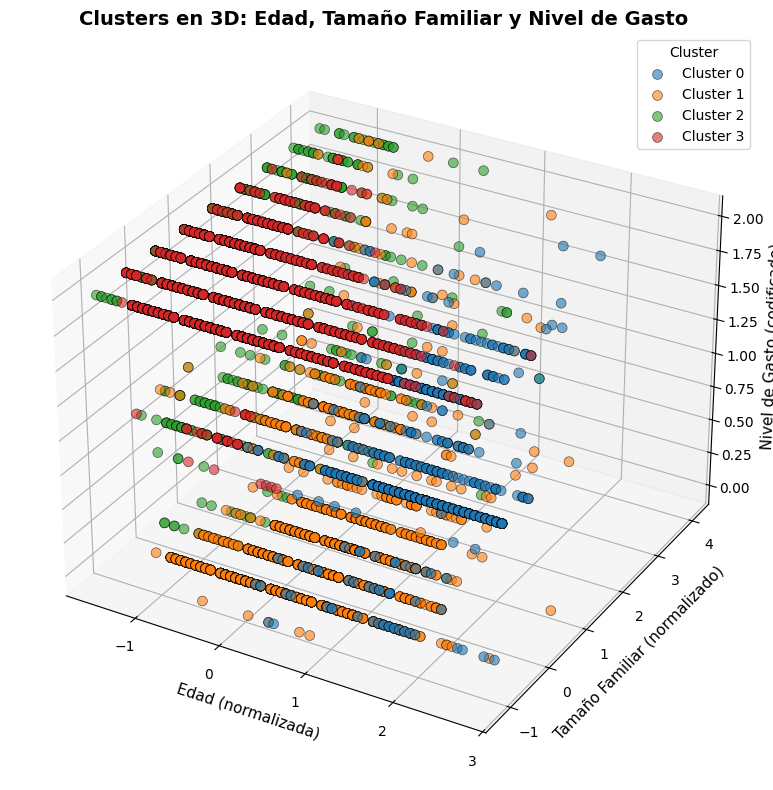

In [176]:
#==============================================================================
# 2. Gráfico de dispersión 3D: Edad, Family_Size y Spending_Score
#==============================================================================
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    cluster_data = X[X['Cluster'] == i]
    ax.scatter(cluster_data['Age'], 
               cluster_data['Family_Size'], 
               cluster_data['Spending_Score_encoded'],
               c=colors[i], label=f'Cluster {i}', s=50, alpha=0.6, edgecolor='black', linewidth=0.5)

ax.set_title('Clusters en 3D: Edad, Tamaño Familiar y Nivel de Gasto', fontsize=14, fontweight='bold')
ax.set_xlabel('Edad (normalizada)', fontsize=11)
ax.set_ylabel('Tamaño Familiar (normalizado)', fontsize=11)
ax.set_zlabel('Nivel de Gasto (codificado)', fontsize=11)
ax.legend(title='Cluster', fontsize=10)
plt.tight_layout()
plt.show()


In [180]:
#==============================================================================
# 3. Perfil promedio de cada cluster (tabla vertical)
#==============================================================================
print('\n=== PERFIL PROMEDIO DE CADA CLUSTER ===')
print('Cada fila representa un cluster, cada columna una característica promedio.\n')

cluster_profile = X.drop('Cluster', axis=1).groupby(X['Cluster']).mean().round(2)
display(cluster_profile)



=== PERFIL PROMEDIO DE CADA CLUSTER ===
Cada fila representa un cluster, cada columna una característica promedio.



,Gender_encoded,Ever_Married_encoded,Graduated_encoded,Profession_encoded,Spending_Score_encoded,Var_1_encoded,Age,Family_Size,Work_Experience_log,Age_bin_encoded,Gasto_por_miembro
Cluster,,,,,,,,,,,
0,0.59,0.90,0.61,6.41,1.40,4.63,1.61,-0.50,-0.34,2.78,0.29
1,0.55,0.99,0.77,0.78,0.20,4.23,0.33,0.21,-0.07,1.66,-1.11
2,0.60,0.33,0.42,4.82,1.68,3.77,-0.76,0.49,0.08,0.63,-0.05
3,0.48,0.39,0.71,0.87,1.99,4.26,-0.17,-0.47,0.11,1.04,0.85


In [182]:
#==============================================================================
# 4. Interpretacion detallada de cada cluster
#==============================================================================
print('\n=== INTERPRETACION DETALLADA DE LOS CLUSTERS ===')
print('\nCaracterísticas promedio de cada segmento de clientes:\n')

# Mapeos para interpretacion
gender_map = {0: 'Femenino', 1: 'Masculino'}
married_map = {0: 'No casado', 1: 'Casado'}
grad_map = {0: 'No graduado', 1: 'Graduado'}
spending_map = {0: 'Alto', 1: 'Promedio', 2: 'Bajo'}  # Basado en LabelEncoder alfabético

for idx in range(4):
    print(f'\n{"-"*70}')
    print(f'CLUSTER {idx} ({cluster_counts[idx]} clientes, {(cluster_counts[idx]/len(X)*100):.1f}%)')
    print(f'{"-"*70}')
    
    row = cluster_profile.loc[idx]
    
    # Interpretación de variables codificadas
    gender_pct = row['Gender_encoded']
    print(f'genero: {"Mayormente Masculino" if gender_pct > 0.5 else "Mayormente Femenino"} ({gender_pct:.0%} masc.)')
    
    married_pct = row['Ever_Married_encoded']
    print(f'Estado civil: {"Mayormente Casados" if married_pct > 0.5 else "Mayormente Solteros"} ({married_pct:.0%} casados)')
    
    grad_pct = row['Graduated_encoded']
    print(f'Educación: {"Mayormente Graduados" if grad_pct > 0.5 else "Mayormente No Graduados"} ({grad_pct:.0%} graduados)')
    
    # Variables numéricas normalizadas
    print(f'Edad (norm.): {row["Age"]:.2f}')
    print(f'Tamaño familiar (norm.): {row["Family_Size"]:.2f}')
    print(f'Experiencia laboral (log norm.): {row["Work_Experience_log"]:.2f}')
    print(f'Nivel de gasto (codif.): {row["Spending_Score_encoded"]:.2f}')
    print(f'Gasto por miembro (norm.): {row["Gasto_por_miembro"]:.2f}')

print(f'\n{"-"*70}')



=== INTERPRETACION DETALLADA DE LOS CLUSTERS ===

Características promedio de cada segmento de clientes:


----------------------------------------------------------------------
CLUSTER 0 (2483 clientes, 30.8%)
----------------------------------------------------------------------
genero: Mayormente Masculino (59% masc.)
Estado civil: Mayormente Casados (90% casados)
Educación: Mayormente Graduados (61% graduados)
Edad (norm.): 1.61
Tamaño familiar (norm.): -0.50
Experiencia laboral (log norm.): -0.34
Nivel de gasto (codif.): 1.40
Gasto por miembro (norm.): 0.29

----------------------------------------------------------------------
CLUSTER 1 (2506 clientes, 31.1%)
----------------------------------------------------------------------
genero: Mayormente Masculino (55% masc.)
Estado civil: Mayormente Casados (99% casados)
Educación: Mayormente Graduados (77% graduados)
Edad (norm.): 0.33
Tamaño familiar (norm.): 0.21
Experiencia laboral (log norm.): -0.07
Nivel de gasto (codif.): 0.20


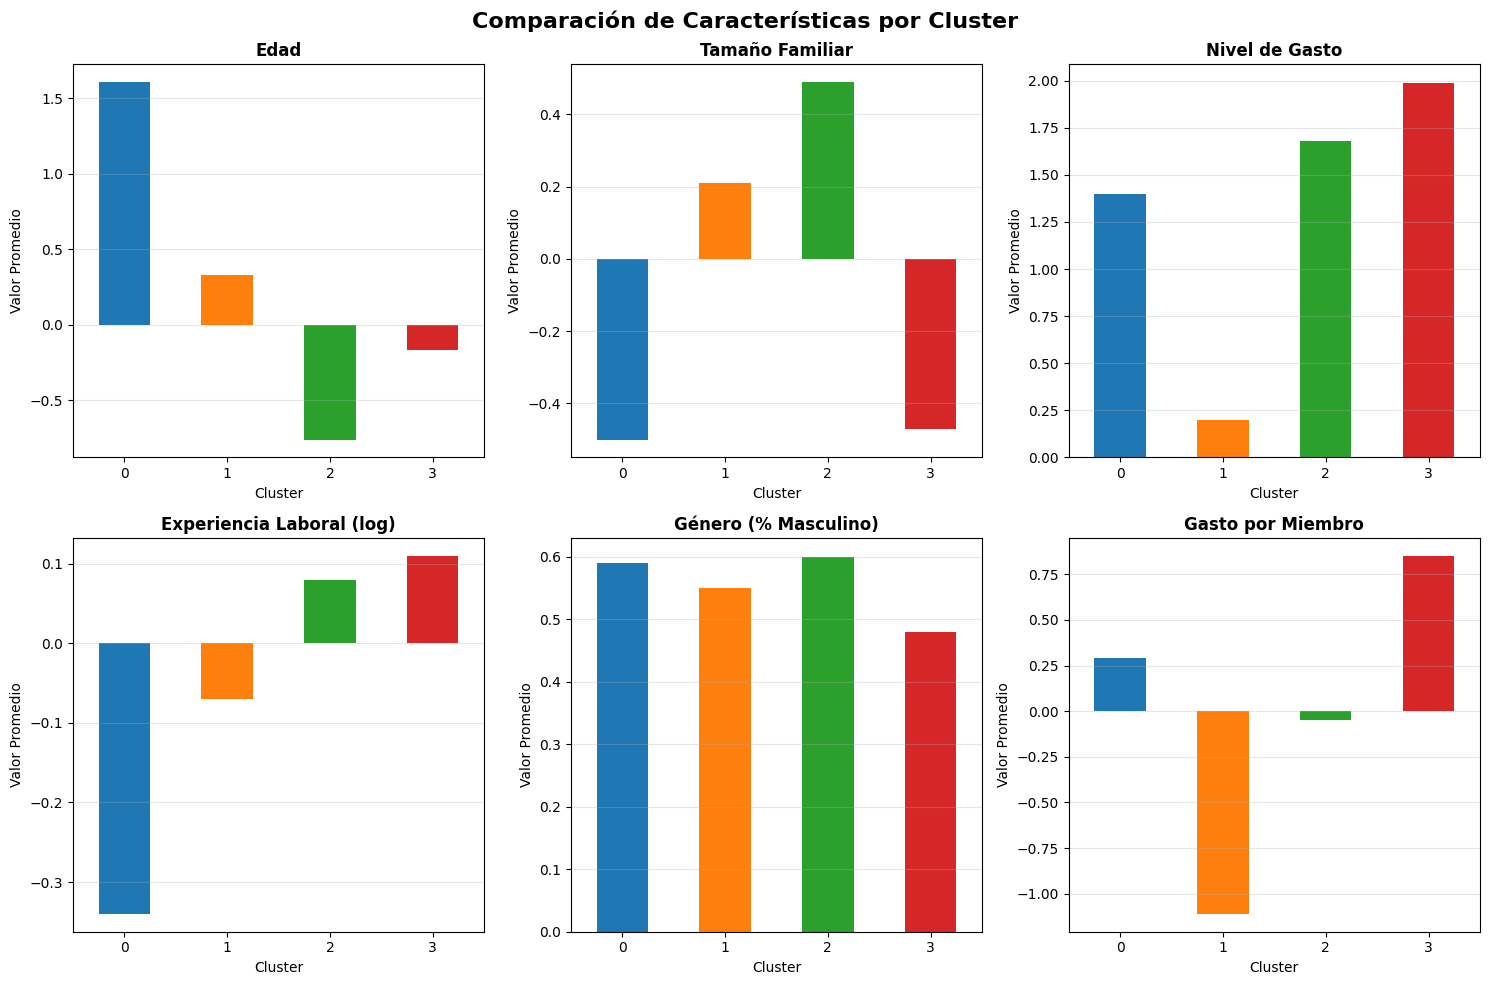


Visualización completada.


In [ ]:

#==============================================================================
# 5. Grafico de barras comparativo por clusters
#==============================================================================
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Caracteristicas por Cluster', fontsize=16, fontweight='bold')

# Variables a comparar
vars_to_plot = ['Age', 'Family_Size', 'Spending_Score_encoded', 
                'Work_Experience_log', 'Gender_encoded', 'Gasto_por_miembro']
titles = ['Edad', 'Tamaño Familiar', 'Nivel de Gasto', 
          'Experiencia Laboral (log)', 'Género (% Masculino)', 'Gasto por Miembro']

for idx, (var, title) in enumerate(zip(vars_to_plot, titles)):
    ax = axes[idx // 3, idx % 3]
    cluster_profile[var].plot(kind='bar', ax=ax, color=colors)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Cluster', fontsize=10)
    ax.set_ylabel('Valor Promedio', fontsize=10)
    ax.set_xticklabels(range(4), rotation=0)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('\nVisualización completada.')

# 4. Evaluación del modelo
Métricas de eficiencia para clustering:
- Inercia (WCSS): mide la compacidad de los clusters
- Lee sobre Silhouette Score: qué tan similares son los objetos a su propio cluster en comparación con otros
- `from sklearn.metrics import silhouette_score score = silhouette_score(X_scaled, clusters)`
- Tiempo de ejecución
- Número de iteraciones hasta la convergencia
- Análisis de estabilidad: repetir K-Means con diferentes inicializaciones y verificar consistencia

In [191]:
# Evaluación del modelo
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import time

print('=== EVALUACIÓN DEL MODELO K-MEANS ===')
print('\nCalculando métricas de calidad del clustering...\n')

#==============================================================================
# 1. Inercia (WCSS) - Within-Cluster Sum of Squares
#==============================================================================
inercia = kmeans_final.inertia_
print(f'1. INERCIA (WCSS): {inercia:.2f}')


=== EVALUACIÓN DEL MODELO K-MEANS ===

Calculando métricas de calidad del clustering...

1. INERCIA (WCSS): 61906.26


In [193]:

#==============================================================================
# 2. Silhouette Score
#==============================================================================
X_sin_cluster = X.drop('Cluster', axis=1)
silhouette_avg = silhouette_score(X_sin_cluster, clusters)
print(f'2. SILHOUETTE SCORE: {silhouette_avg:.4f}')
if silhouette_avg > 0.5:
    print('Excelente estructura de clusters')
elif silhouette_avg > 0.3:
    print('Estructura razonable de clusters')
else:
    print('Estructura débil de clusters')
print()


2. SILHOUETTE SCORE: 0.2283
Estructura débil de clusters



In [195]:

#==============================================================================
# 3. Tiempo de ejecución
#==============================================================================
print(f'3. ANÁLISIS DE TIEMPO DE EJECUCIÓN:')
print(f'   Midiendo tiempo de ejecución con diferentes inicializaciones...\n')

tiempos = []
for i in range(5):
    start_time = time.time()
    kmeans_test = KMeans(n_clusters=4, random_state=i, n_init=10)
    kmeans_test.fit(X_sin_cluster)
    end_time = time.time()
    tiempo = end_time - start_time
    tiempos.append(tiempo)
    print(f'   Ejecución {i+1}: {tiempo:.4f} segundos')

tiempo_promedio = sum(tiempos) / len(tiempos)
print(f'\n   • Tiempo promedio: {tiempo_promedio:.4f} segundos')
print(f'   • Tiempo mínimo: {min(tiempos):.4f} segundos')
print(f'   • Tiempo máximo: {max(tiempos):.4f} segundos\n')


3. ANÁLISIS DE TIEMPO DE EJECUCIÓN:
   Midiendo tiempo de ejecución con diferentes inicializaciones...

   Ejecución 1: 0.0562 segundos
   Ejecución 2: 0.0447 segundos
   Ejecución 3: 0.0494 segundos
   Ejecución 4: 0.0557 segundos
   Ejecución 5: 0.0499 segundos

   • Tiempo promedio: 0.0512 segundos
   • Tiempo mínimo: 0.0447 segundos
   • Tiempo máximo: 0.0562 segundos

   Ejecución 5: 0.0499 segundos

   • Tiempo promedio: 0.0512 segundos
   • Tiempo mínimo: 0.0447 segundos
   • Tiempo máximo: 0.0562 segundos



In [200]:

#==============================================================================
# 4. Analisis de estabilidad
#==============================================================================
print(f'4. ANALISIS DE ESTABILIDAD:')
print(f'   Comparando resultados con diferentes inicializaciones...\n')

silhouette_scores = []
inertias = []

for i in range(10):
    kmeans_stability = KMeans(n_clusters=4, random_state=i, n_init=10)
    clusters_stability = kmeans_stability.fit_predict(X_sin_cluster)
    
    sil_score = silhouette_score(X_sin_cluster, clusters_stability)
    silhouette_scores.append(sil_score)
    inertias.append(kmeans_stability.inertia_)

print(f'   Silhouette Score:')
print(f'   Promedio: {sum(silhouette_scores)/len(silhouette_scores):.4f}')
print(f'   Desviación estándar: {np.std(silhouette_scores):.4f}')
print(f'   Rango: [{min(silhouette_scores):.4f}, {max(silhouette_scores):.4f}]\n')

print(f'   Inercia (WCSS):')
print(f'   Promedio: {sum(inertias)/len(inertias):.2f}')
print(f'   Desviación estándar: {np.std(inertias):.2f}')
print(f'   Rango: [{min(inertias):.2f}, {max(inertias):.2f}]\n')

print(f'   Conclusión: El modelo es {"ESTABLE" if np.std(silhouette_scores) < 0.01 else "VARIABLE"} ', 'a diferentes inicializaciones.\n')


4. ANALISIS DE ESTABILIDAD:
   Comparando resultados con diferentes inicializaciones...

   Silhouette Score:
   Promedio: 0.2284
   Desviación estándar: 0.0000
   Rango: [0.2284, 0.2284]

   Inercia (WCSS):
   Promedio: 61906.18
   Desviación estándar: 0.00
   Rango: [61906.18, 61906.18]

   Conclusión: El modelo es ESTABLE  a diferentes inicializaciones.

   Silhouette Score:
   Promedio: 0.2284
   Desviación estándar: 0.0000
   Rango: [0.2284, 0.2284]

   Inercia (WCSS):
   Promedio: 61906.18
   Desviación estándar: 0.00
   Rango: [61906.18, 61906.18]

   Conclusión: El modelo es ESTABLE  a diferentes inicializaciones.

   Silhouette Score:
   Promedio: 0.2284
   Desviación estándar: 0.0000
   Rango: [0.2284, 0.2284]

   Inercia (WCSS):
   Promedio: 61906.21
   Desviación estándar: 0.03
   Rango: [61906.18, 61906.24]

   Conclusión: El modelo es ESTABLE  a diferentes inicializaciones.

   Silhouette Score:
   Promedio: 0.2284
   Desviación estándar: 0.0000
   Rango: [0.2284, 0.2284]